In [113]:
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import pymongo

In [114]:
# Wait for the databases to be ready.
def wait_for_services():
    time.sleep(10)  # Wait for 10 seconds for the services to start.

In [115]:
# MySQL connection.
mysql_conn = pymysql.connect(host='localhost', user='root', password='root')
mysql_cursor = mysql_conn.cursor()

In [116]:
# Create the database if it doesn't exist.
mysql_cursor.execute("CREATE DATABASE IF NOT EXISTS test_db;")
mysql_cursor.execute("USE test_db;")

0

In [117]:
# Create MySQL table.
mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS FTIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        FULLTEXT(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS IDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        INDEX(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS NOIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255)
    );
""")

0

In [118]:
# MongoDB connection.
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["test_db"]

In [119]:
# Create MongoDB collection.
# Full-text index.
FTIDX_collection = mongo_db["FTIDX_collection"]
FTIDX_collection.create_index([("name", pymongo.TEXT)])

# Regular index (in ascending order).
IDX_collection = mongo_db["IDX_collection"]
IDX_collection.create_index([("name", 1)])

# No index, except MongoDB's default index, _id.
NOIDX_collection = mongo_db["NOIDX_collection"]
NOIDX_collection.drop_indexes()

In [120]:
# Function to insert data into MySQL.
def insert_data_mysql(table, data, transactional=True):
    if transactional:
        mysql_conn.begin() # Start transaction.
    sql = f"INSERT INTO {table} (name, country) VALUES (%s, %s)"
    mysql_cursor.execute(sql, data)
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [121]:
# Function to insert data into MongoDB.
# In MongoDB, every single document insert is an atomic operation.
def insert_data_mongo(index_type, data, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                if index_type == "FTIDX":
                    FTIDX_collection.insert_one(data)
                elif index_type == "IDX":
                    IDX_collection.insert_one(data)
                else:
                    NOIDX_collection.insert_one(data)
    else:
        if index_type == "FTIDX":
            FTIDX_collection.insert_one(data)
        elif index_type == "IDX":
            IDX_collection.insert_one(data)
        else:
            NOIDX_collection.insert_one(data)

In [122]:
# Function to delete data from MySQL.
def delete_data_mysql(table, name, transactional=True):
    if transactional:
        mysql_conn.begin()  # Start transaction.
    sql = f"DELETE FROM {table} WHERE name = %s"
    mysql_cursor.execute(sql, (name,))
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [123]:
# Delete data from MongoDB.
# MongoDB does not have explicit transactions for single operations.
def delete_data_mongo(collection, name, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                if index_type == "FTIDX":
                    FTIDX_collection.delete_one({"name": name})
                elif index_type == "IDX":
                    IDX_collection.delete_one({"name": name})
                else:
                    NOIDX_collection.delete_one({"name": name})
    else:
        if index_type == "FTIDX":
            FTIDX_collection.delete_one({"name": name})
        elif index_type == "IDX":
            IDX_collection.delete_one({"name": name})
        else:
            NOIDX_collection.delete_one({"name": name})

In [124]:
# Use faker library to generate fake data.
# from faker import Faker

# fake = Faker()
# id_ = random.randint(1, 10000)
# name = fake.city()
# country = fake.country()
# coord = (str(faker.longitude()), str(faker.latitude()))

# Generate fake sample data.
def create_sample_data(num_records):
    sample_data = []
    for i in range(num_records):
        sample_data.append({
            "id": i,
            "name": f"City_{i}",
            "country": "RU",
            "coord": {"lon": random.uniform(-180, 180), "lat": random.uniform(-90, 90)}
        })
    return sample_data

In [125]:
# Experiment.
# Types of Queries:
#   A. Indexes:
#       1. FTIDX: Full-text indexing for efficient text searches.
#       2. IDX: Regular indexing for general query optimization.
#       3. NOIDX: No indexing, leading to potential performance issues for queries.
#   B. Transactional:
#      1. Transaction
#      2. Non-transaction

results = []
for i in range(100):
    # Generate random data.
    name = f"City_{random.randint(1, 1000)}"
    country = "IN"
    
    # Insert data with different conditions.
    for index_type in ['FTIDX', 'IDX', 'NOIDX']:
    	for transactional in [True, False]:
        	# Measure insert time.
        	start_time = time.time()
        	insert_data_mysql("_".join([index_type, "table"]), (name, country), transactional)
        	mysql_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	insert_data_mongo(index_type, {"name": name, "country": country}, transactional)
        	mongo_duration = (time.time() - start_time) * 1000
        	
        	# Measure delete time.
        	start_time = time.time()
        	delete_data_mysql("_".join([index_type, "table"]), name, transactional)
        	mysql_delete_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	delete_data_mongo(index_type, name, transactional)
        	mongo_delete_duration = (time.time() - start_time) * 1000
        	
        	# Store results.
        	results.append({
        		"Index Type": index_type,
        		"Transaction": "TX" if transactional else "NOTX",
        		"MySQL Insert Time (ms)": mysql_duration,
        		"MongoDB Insert Time (ms)": mongo_duration,
        		"MySQL Delete Time (ms)": mysql_delete_duration,
        		"MongoDB Delete Time (ms)": mongo_delete_duration
        	})

In [126]:
# Convert results to Pandas' DataFrame.
results_df = pd.DataFrame(results)
results_df.head

<bound method NDFrame.head of     Index Type Transaction  MySQL Insert Time (ms)  MongoDB Insert Time (ms)  \
0        FTIDX          TX               20.822763                  1.385689   
1        FTIDX        NOTX                0.703812                  1.053810   
2          IDX          TX               21.986961                  1.289368   
3          IDX        NOTX                0.593185                  0.986814   
4        NOIDX          TX               19.413471                 42.920113   
..         ...         ...                     ...                       ...   
595      FTIDX        NOTX                0.554323                  0.756979   
596        IDX          TX               14.359236                  1.110077   
597        IDX        NOTX                0.574112                  0.788689   
598      NOIDX          TX               14.493942                  1.013756   
599      NOIDX        NOTX                0.485182                  0.725746   

     MySQ

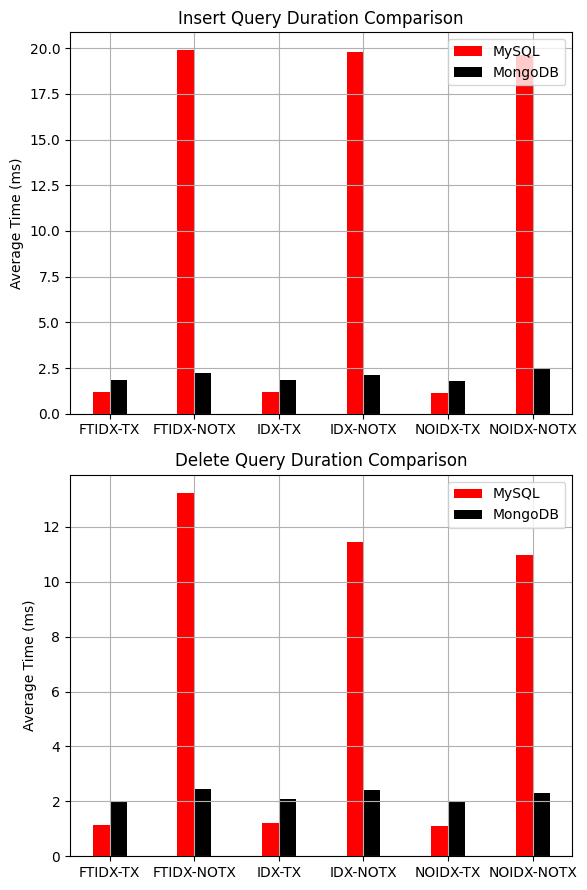

In [127]:
# Create a new column for combined labels.
results_df['Label'] = results_df['Index Type'] + '-' + results_df['Transaction']

# Set the bar width.
bar_width = 0.2

# Create subplots for each query type.
fig, axs = plt.subplots(2, 1, figsize=(6, 9))

# Define query types and their corresponding column names.
query_types = ['Insert', 'Delete']
mysql_columns = ['MySQL Insert Time (ms)', 'MySQL Delete Time (ms)']
mongo_columns = ['MongoDB Insert Time (ms)', 'MongoDB Delete Time (ms)']

# Loop through each query type and create a bar plot.
for i, query in enumerate(query_types):
    # Set the positions of the bars on the x-axis.
    x = np.arange(len(results_df['Label'].unique()))
    
    # Plot MySQL and MongoDB times for the current query type.
    axs[i].bar(x - bar_width/2,
               results_df.groupby('Label')[mysql_columns[i]].mean(),
               width=bar_width,
               label='MySQL', color='red')
    
    axs[i].bar(x + bar_width/2, 
               results_df.groupby('Label')[mongo_columns[i]].mean(), 
               width=bar_width, 
               label='MongoDB', color='black')
    
    # Set the x-ticks and labels.
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(results_df['Label'].unique())
    axs[i].set_title(f'{query} Query Duration Comparison')
    axs[i].set_ylabel('Average Time (ms)')
    axs[i].legend()
    axs[i].grid()

# Adjust layout and show the plots.
plt.tight_layout()
plt.show()

In [128]:
# Close connections.
# TODO: Uncomment all commands.
# mysql_cursor.close()
# mysql_conn.close()
# mongo_client.close()